<a href="https://colab.research.google.com/github/maritverboom/TM10007_PROJECT/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment 


In [18]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

## Data Loading

In [34]:
from hn.load_data import load_data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# seperate the data in features and tumorstage
hn_stage = data['label']          # dataframe containing tumor stadium of subject (T12/T34)
hn_features = data.drop(columns='label') # dataframe containing all feature columns except 'label' (tumor stadium of subject)

# Binarize label data
hn_stage = preprocessing.label_binarize(hn_stage, ['T12', 'T34'])
hn_stage = [i[0] for i in hn_stage]

The number of samples: 113
The number of columns: 160


## Splitting data

Below is a function to split the dataframe into two different dataframes (e.g. the train- and testset). This is done for both the features dataframe as well as the stage dataframe.

Nadenken over de verhouding train/test-set

In [35]:
# Splitting the data in train- and testpart with a portion of 'test_size' training data (20%)
data_train, data_test, stage_train, stage_test = model_selection.train_test_split(hn_features, hn_stage, test_size=0.20)

print(f'The number of rows of train data : {len(data_train.index)}')
print(f'The number of rows of test data : {len(data_test.index)}')

The number of rows of train data : 90
The number of rows of test data : 23


## Preprocessing

- column verdwijnt als >25% van de column een 0 bevat. Dit heb ik gedaan omdat het vervangen van alle 0 voor NaN me niet heel handig leek, omdat je die 0 soms wel wilt gebruiken als het echt als waarde voorkomt.
- we kunnen nog proberen om 'missende' waardes op te vullen met 'feature imputation' zoals besproken in het college van 26/03

In [37]:
# Imputation
#imp = SimpleImputer(missing_values=np.nan, strategy='median')
#imp.fit(data_train)
#data_train = imp.transform(data_train)
#data_test = imp.transform(data_test)

# Remove all columns where more than 25% of the values are 0.0
drop_cols = hn_features.columns[(hn_features == 0).sum() > 0.25*hn_features.shape[1]]
hn_features.drop(drop_cols, axis = 1, inplace = True) 

# Remove all columns with low variance (based on threshold): sklearn.feature_selection.VarianceThreshold()

print(f'The number of columns after preprocessing: {len(hn_features.columns)}')
print(f'The number of rows after preprocessing: {len(hn_features.index)}')


The number of columns after preprocessing: 152
The number of rows after preprocessing: 113


## Data Scaling

Overwegen welk van de onderstaande het beste is voor onze data! 

StandardScaler removes the mean and scales the data to unit variance.  cannot guarantee balanced feature scales in the presence of outliers.

MinMaxScaler rescales the data set such that all feature values are in the range [0, 1], very sensitive to outliers

Robust scaler. Unlike the previous scalers, the centering and scaling statistics of this scaler are based on percentiles and are therefore not influenced by a few number of very large marginal outliers.

Read more: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
 

In [0]:
# Scale the data (train on train set)
scaler = preprocessing.StandardScaler()   
scaler.fit(data_train)  

# Perform scaling on both train and testset
data_train_scaled = scaler.transform(data_train)
data_test_scaled = scaler.transform(data_test) 

## Feature selection/extraction

Feature ranking with recursive feature elimination and cross-validated selection of the best number of features.


Variabelen
- stratifiedKfold(x), x veranderen geeft hele andere uitkomsten
- step = x, x laten als 1!

! Dit gebruiken we nu nog niet


https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV

- Univariate testing: select best performing features based on statistical test: sklearn.feature_selection.SelectKBest()

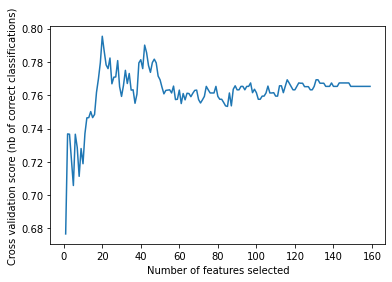

Num Features: 20
Selected Features: [False False  True False False False False False  True False False False
 False False False False False False  True False False  True False False
 False False False False False False False False False False False False
 False False False False False  True False  True False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False  True False False False False
  True False False  True False False False False  True False False False
 False  True False False  True False False  True  True False False False
 False False False  True  True False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
  True False Fa

In [39]:
# Recursive Feature Elimination
svc = svm.SVC(kernel="linear")  # Create the RFE object and compute a cross-validated score.

# classifications
rfecv = feature_selection.RFECV(
    estimator=svc, step=1, 
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
fit = rfecv.fit(data_train_scaled, stage_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)


## Principal Component Analysis (PCA)
- nu voor eerste 20 features, bedenken hoe veel we er willen

In [31]:
# Create a function for calculating PCA
def pca(data_train, data_test):
    """
    Function for PCA

        data_train = training data
        data_test = testing data

    Output is transformed train- and testdata
    """

    # Create and fit a PCA with 20 components
    pca_train = PCA(n_components=20)
    pca_train.fit(data_train)

    # Transform data using PCA
    data_train_trans = pca_train.transform(data_train)
    data_test_trans = pca_train.transform(data_test)

    # Return transformed train- and testdata
    return data_train_trans, data_test_trans

data_train_pca, data_test_pca = pca(data_train_scaled, data_test_scaled)
print(data_train_pca)

[[  8.23727317   2.29415261   1.24408809 ...   0.07033045  -0.14126902
    0.9386705 ]
 [  2.51003217  -4.92123808   0.81396694 ...  -0.37796289  -2.03255189
    0.27795685]
 [ -6.81653526  -2.55055876  -8.8964551  ...  -3.0879508    3.99900363
    0.97364012]
 ...
 [ -6.18985497  -5.06250734  -4.58955086 ...   0.20999856   2.72470747
    1.44265765]
 [-11.50438286   9.89718257  -4.88070877 ...  -2.72995396   2.5903002
    0.56375314]
 [  0.02486466   2.07489257   3.08376994 ...  -1.36434622  -1.08138069
    0.25606184]]


## kNN
- functie gemaakt om adhv kNN de labels te voorspellen

In [0]:
def knn_classifier(num_neighbors, data_train, data_test, label_train, label_test):
    """
    Function for kNN training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        
    Output is two lists with the predicted class of the train- and testdata 
    """
    knn = neighbors.KNeighborsClassifier(n_neighbors = num_neighbors)
    knn.fit(data_train, label_train)
    label_train_knn = knn.predict(data_train)
    label_test_knn = knn.predict(data_test)
    score_train = knn.score(data_train, label_train)
    score_test = knn.score(data_test, label_test)
    return score_train, score_test, label_train_knn, label_test_knn

score_train_knn, score_test_knn, stage_train_knn, stage_test_knn = knn_classifier(15, data_train_pca, data_test_pca, stage_train, stage_test)
print(score_train_knn, score_test_knn) # accuracy


0.6777777777777778 0.6521739130434783


## Support Vector Machine (SVM)
-  Geeft nu alleen een kernel mee, maar heeft nog veel meer parameters
- test_decision = svc.decision_function(data_test) kunnen we later miss nog gebruiken om een ROC te maken

In [0]:
def svm_classifier(data_train, data_test, label_train, label_test, svm_kernel):
    """
    Function for SVM training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        svm_kernel = different kernels to be used (type = string)

    Output is two lists with the predicted class of the train- and testdata
    """
    svc = svm.SVC(kernel=svm_kernel)
    svc.fit(data_train, label_train)

    # Predict the classes of the data 
    label_train_svm = svc.predict(data_train)
    label_test_svm= svc.predict(data_test)
    
    return label_train_svm, label_test_svm

stage_train_svm, stage_test_svm = svm_classifier(data_train_pca, data_test_pca, stage_train, stage_test, 'linear')
print(stage_test_svm)

[1 0 1 1 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0]


## Random Forest Classifier 
- alle parameters nog bepalen


In [0]:
def rfc_classifier(data_train, data_test, label_train, label_test):
    """
    Function for RFC training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        
    Output is two lists with the predicted class of the train- and testdata 
    """
    # Create Random Forest Classifier and fit classifier on traindata
    rfc = RandomForestClassifier(max_depth=2)
    rfc.fit(data_train, label_train)

    # Predict labels for train- and testdata
    label_train_rfc = rfc.predict(data_train)
    label_test_rfc = rfc.predict(data_test)

    return label_train_rfc, label_test_rfc

stage_train_rfc, stage_test_rfc = rfc_classifier(data_train_pca, data_test_pca, stage_train, stage_test)
print(stage_test_rfc)


[1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0]


## Performance
- Functie gemaakt om een dataframe te maken van de performance van een bepaalde classifier
- Uiteindelijke mooier om alles er tegelijk in te kunnen gooien met een loop en dan 1 groot dataframe te maken

In [0]:
def performance_clf(predlabel_train, label_train, predlabel_test, label_test):
    """
    Function to calculate performance of a classifier:

        predlabel_train = predicted label of traindata 
        label_train = real label of traindata
        predlabel_test = predicted label of testdata
        label_test = real label of testdata
    
    This function returns a dataframe of the calculated AUC, accuracy, F1-score,
    precision and recall of the classifier for the train- and testdata
    """
    
    # Performance train set
    auc_train=metrics.roc_auc_score(predlabel_train, label_train)
    accuracy_train=metrics.accuracy_score(predlabel_train, label_train)
    F1_train=metrics.f1_score(predlabel_train, label_train)
    precision_train=metrics.precision_score(predlabel_train, label_train)
    recall_train=metrics.recall_score(predlabel_train, label_train)
    
    # Performance test set
    auc_test=metrics.roc_auc_score(predlabel_test, label_test)
    accuracy_test=metrics.accuracy_score(predlabel_test, label_test)
    F1_test=metrics.f1_score(predlabel_test, label_test)
    precision_test=metrics.precision_score(predlabel_test, label_test)
    recall_test=metrics.recall_score(predlabel_test, label_test)

    performance = {'train': [auc_train, accuracy_train, F1_train, precision_train, recall_train],
                   'test': [auc_test, accuracy_test, F1_test, precision_test, recall_test]}
    frame_performance = pd.DataFrame(data=performance, index=['auc', 'accuracy', 'F1', 'precision', 'recall'])
  
    return frame_performance

performance_knn = performance_clf(stage_train_knn, stage_train, stage_test_knn, stage_test)
performance_svm = performance_clf(stage_train_svm, stage_train, stage_test_svm, stage_test)
performance_rfc = performance_clf(stage_train_rfc, stage_train, stage_test_rfc, stage_test)


print(f'The performance of the kNN-classifier is: {performance_knn}')
print(f'The performance of the SVM-classifier is: {performance_svm}')
print(f'The performance of the RFC-classifier is: {performance_rfc}')


The performance of the kNN-classifier is:               train      test
auc        0.740642  0.777778
accuracy   0.677778  0.652174
F1         0.743363  0.714286
precision  0.933333  1.000000
recall     0.617647  0.555556
The performance of the SVM-classifier is:               train      test
auc        0.855731  0.780303
accuracy   0.855556  0.782609
F1         0.853933  0.761905
precision  0.844444  0.800000
recall     0.863636  0.727273
The performance of the RFC-classifier is:               train      test
auc        0.922431  0.707692
accuracy   0.922222  0.695652
F1         0.923077  0.695652
precision  0.933333  0.800000
recall     0.913043  0.615385
